# UTS KS RPLD

Dataset yang digunakan dalam notebook ini adalah dataset E (dapat diakses di: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/tasks?taskId=508) yang tersedia di Elok Kapita Selekta Rekayasa Perangkat Lunak dan Data. Dataset tersebut berisi update kasus virus Covid-19 yang tercatat dari berbagai negara di seluruh dunia.

Berikut adalah Exploratory Data Analysis serta Data Mining yang saya lakukan dari dataset tersebut:

## Persiapan Data
Sebagai persiapan, import terlebih dahulu libraries dan dataset yang akan digunakan.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_rows = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing

In [2]:
covid = pd.read_csv(r'C:\Users\ACER\Desktop\UTS_KSRPLD\covid_19_data.csv', delimiter = ',')

covid.head(5)

SNo ObservationDate Province/State Country/Region      Last Update  \
0    1      01/22/2020          Anhui          China  1/22/2020 17:00   
1    2      01/22/2020        Beijing          China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing          China  1/22/2020 17:00   
3    4      01/22/2020         Fujian          China  1/22/2020 17:00   
4    5      01/22/2020          Gansu          China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

In [3]:
covid.shape

(9424, 8)

Dalam dataset yang digunakan, terdapat 9424 log dalam barisnya dan 8 kolom informasi. Karena ada beberapa kolom yang tidak relevan dalam pembuatan EDA, seperti 'SNo' dan 'Last Update' maka kolom tersebut akan didrop terlebih dahulu sebelum melanjutkan.

In [4]:
covid = covid.drop(['SNo', 'Last Update'], axis=1)

Kemudian, kolom-kolom yang tersisa di dataset akan dinamakan ulang menggunakan kata yang lebih familiar untuk memudahkan pemanggilannya.

In [5]:
covid.rename(columns={'ObservationDate': 'date', 
                      'Province/State': 'province',
                      'Country/Region': 'country',
                      'Confirmed': 'confirmed', 
                      'Deaths': 'deaths', 
                      'Recovered': 'recovered'},
                        inplace = True)

covid['active'] = covid['confirmed'] - covid['deaths'] - covid['recovered']

Dengan begitu, kolom yang ada sekarang penyebutannya berubah seperti berikut:
1. ObservationDate → date
2. Province/State → province
3. Country/Region → country
4. Deaths → deaths
5. Recovered → recovered

Selain itu, dalam dataset ini juga ditambahkan kolom 'active', yaitu jumlah kasus terkonfirmasi dikurangi angka kematian dan angka kesembuhan pasien.

Selanjutnya, tipe data pada kolom 'date' (sebelumnya 'ObservationDate') akan diganti menjadi datatype 'datetime' yang diinput dari modul datetime.

In [6]:
covid['date'] = pd.to_datetime(covid['date'])

## Informasi Awal Mengenai Dataset

Untuk mengecek tipe data pada tiap kolom, dapat kita gunakan kode di bawah ini:

In [7]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       9424 non-null   datetime64[ns]
 1   province   5167 non-null   object        
 2   country    9424 non-null   object        
 3   confirmed  9424 non-null   float64       
 4   deaths     9424 non-null   float64       
 5   recovered  9424 non-null   float64       
 6   active     9424 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 515.5+ KB


Dari hasil tersebut, dapat diketahui bahwa:
1. 'date' memiliki data type datetime
2. 'province' dan 'country' memiliki data type object
3. 'confirmed', 'deaths', 'recovered', dan 'active' memiliki data type float

Lalu kita akan melihat rangkuman statistik dataset yang dipakai.

In [8]:
covid.describe(include = 'object')

province country
count         5167    9424
unique         150     203
top     California   China
freq           294    2044

Dalam tabel di atas, dapat diketahui bahwa:
1. Terdapat setidaknya 150 provinsi berbeda yang dilaporkan kasus Covid-19-nya dalam dataset ini, namun tidak semua negara dicantumkan provinsinya (hanya ada 5167 nilai dari 9424 kolom). Provinsi yang paling sering disebut dalam sel data adalah California dengan frekuensi 294 update.
2. Terhitung setidaknya 203 negara atau teritori* berbeda yang dilaporkan kasus Covid-19-nya dalam dataset ini. China merupakan negara yang paling sering disebut dalam sel data dengan frekuensi 2044 update.

**Disebut teritori karena terdapat kasus yang dilaporkan dari sejumlah kapal pesiar dari seluruh dunia*


Setelah mengetahui informasi di atas, korelasi antar data akan dilihat menggunakan kode di bawah ini.

In [9]:
covid.corr()

confirmed    deaths  recovered    active
confirmed   1.000000  0.899998   0.797015  0.860830
deaths      0.899998  1.000000   0.676817  0.792158
recovered   0.797015  0.676817   1.000000  0.379628
active      0.860830  0.792158   0.379628  1.000000

Dalam korelasi antar data tersebut, dapat disimpulkan bahwa kasus terkonfirmasi berkaitan dengan angka kematian (sebanyak 0,89), kasus aktif (0,86), dan angka kesembuhan (sebanyak 0,79).

## Exploratory Data Analysis

Untuk memulai EDA pada notebook ini, akan diawali dengan mencaritahu tanggal dari update pertama dan update terakhir dataset.

In [10]:
tanggal = covid.date.value_counts().sort_index()
print('Tanggal pertama:',tanggal.index[0])
print('Tanggal terakhir:',tanggal.index[-1])

Tanggal pertama: 2020-01-22 00:00:00
Tanggal terakhir: 2020-03-27 00:00:00


Dapat diketahui bahwa update pertama dataset melaporkan kasus yang terkonfirmasi pada tanggal 22 Januari 2020, sedangkan update terakhir melaporkan kasus yang terkonfirmasi pada tanggal 27 Maret 2020. Jadi, terdapat tiga bulan rentang waktu dalam dataset.

### Seluruh Dunia

Pencarian informasi akan dilanjutkan dengan menampilkan kasus aktif Covid-19 berdasarkan negaranya per tanggal 27 Maret 2020.

In [11]:
terbaru = covid[covid['date'] == covid['date'].max()]
dunia = terbaru.groupby('country')['confirmed', 'active', 'deaths', 'recovered'].sum().reset_index()
dunia

country  confirmed   active  deaths  recovered
0                         Afghanistan      110.0    104.0     4.0        2.0
1                             Albania      186.0    147.0     8.0       31.0
2                             Algeria      409.0    354.0    26.0       29.0
3                             Andorra      267.0    263.0     3.0        1.0
4                              Angola        4.0      4.0     0.0        0.0
5                 Antigua and Barbuda        7.0      7.0     0.0        0.0
6                           Argentina      589.0    504.0    13.0       72.0
7                             Armenia      329.0    300.0     1.0       28.0
8                           Australia     3143.0   2936.0    13.0      194.0
9                             Austria     7657.0   7374.0    58.0      225.0
10                         Azerbaijan      165.0    147.0     3.0       15.0
11                            Bahrain      466.0    235.0     4.0      227.0
12                         Bangladesh       48.0     32.0     5.0       11.0
13                           Barbados       24.0     24.0     0.0        0.0
14                            Belarus       94.0     62.0     0.0       32.0
15                            Belgium     7284.0   6137.0   289.0      858.0
16                             Belize        2.0      2.0     0.0        0.0
17                              Benin        6.0      6.0     0.0        0.0
18                             Bhutan        3.0      3.0     0.0        0.0
19                            Bolivia       61.0     61.0     0.0        0.0
20             Bosnia and Herzegovina      237.0    228.0     4.0        5.0
21                             Brazil     3417.0   3319.0    92.0        6.0
22                             Brunei      115.0    104.0     0.0       11.0
23                           Bulgaria      293.0    281.0     3.0        9.0
24                       Burkina Faso      180.0    159.0     9.0       12.0
25                              Burma        8.0      8.0     0.0        0.0
26                         Cabo Verde        5.0      4.0     1.0        0.0
27                           Cambodia       99.0     88.0     0.0       11.0
28                           Cameroon       91.0     87.0     2.0        2.0
29                             Canada     4669.0   4360.0    53.0      256.0
30           Central African Republic        3.0      3.0     0.0        0.0
31                               Chad        3.0      3.0     0.0        0.0
32                              Chile     1610.0   1562.0     5.0       43.0
33                              China    81345.0   3453.0  3292.0    74600.0
34                           Colombia      539.0    523.0     6.0       10.0
35                              Congo       55.0     50.0     3.0        2.0
36                         Costa Rica      263.0    258.0     2.0        3.0
37                            Croatia      586.0    546.0     3.0       37.0
38                               Cuba       80.0     74.0     2.0        4.0
39                             Cyprus      162.0    142.0     5.0       15.0
40                     Czech Republic     2279.0   2259.0     9.0       11.0
41                            Denmark     2200.0   2091.0    52.0       57.0
42                           Djibouti       12.0     12.0     0.0        0.0
43                           Dominica       11.0     11.0     0.0        0.0
44                 Dominican Republic      581.0    558.0    20.0        3.0
45                            Ecuador     1595.0   1556.0    36.0        3.0
46                              Egypt      536.0    390.0    30.0      116.0
47                        El Salvador       13.0     13.0     0.0        0.0
48                  Equatorial Guinea       12.0     12.0     0.0        0.0
49                            Eritrea        6.0      6.0     0.0        0.0
50                            Estonia      575.0    563.0     1.0       11.0
51                        

Melalui penampilan data di atas, dapat disimpulkan bahwa per tanggal 27 Maret 2020 hanya terdapat 176 negara dan teritori berbeda yang memiliki kasus aktif hingga sekarang. Ini dikarenakan update yang dicantumkan di dataset mengikuti perkembangan terbaru, oleh sebab itu terdapat beberapa negara yang tidak lagi disebut dalam tabel di atas.

Informasi di atas dapat diolah untuk perhitungan mortality rate dan recovery rate di seluruh dunia, yaitu seperti berikut.

In [12]:
pertanggal = covid.groupby('date').agg({"confirmed": 'sum', "recovered": 'sum', "deaths": 'sum'})

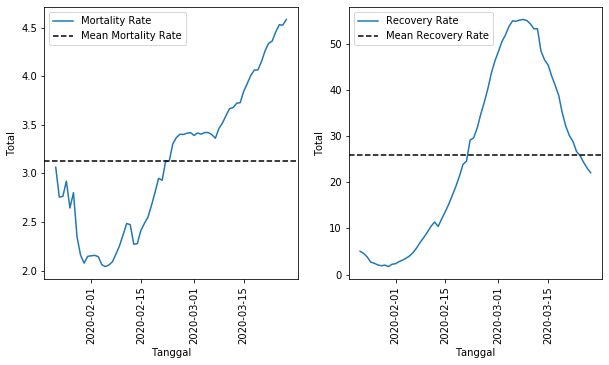

In [13]:
pertanggal["Mortality Rate"]=(pertanggal["deaths"]/pertanggal["confirmed"])*100
pertanggal["Recovery Rate"]=(pertanggal["recovered"]/pertanggal["confirmed"])*100

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(pertanggal["Mortality Rate"],label='Mortality Rate')
ax1.axhline(pertanggal["Mortality Rate"].mean(),linestyle='--',color='black',label="Mean Mortality Rate")
ax1.set_ylabel("Total")
ax1.set_xlabel("Tanggal")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(pertanggal["Recovery Rate"],label="Recovery Rate")
ax2.axhline(pertanggal["Recovery Rate"].mean(),linestyle='--',color='black',label="Mean Recovery Rate")
ax2.set_ylabel("Total")
ax2.set_xlabel("Tanggal")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

Dari grafik di atas, dapat dilihat bahwa:
1. Awalnya mortality rate melonjak turun, terutama pada tanggal 1 Februari 2020 (di bawah 2,5). Kemudian, grafiknya mulai menaik secara bertahap, walaupun sempat berada di tempat yang relatif sama pada akhir bulan Februari. 
2. Awalnya recovery rate menurun pada akhir Januari, kemudian menaik secara tetap hingga awal Maret. Meski begitu di awal minggu kedua Maret, recovery rate menurun kembali hingga di bawah mean recovery rate sampai update terakhir.

Kemudian kita akan melihat perkembangan kasus Covid-19 dengan membandingkan tiap-tiap kategori kasus yang terkonfirmasi.

Text(0, 0.5, 'Total Kasus')

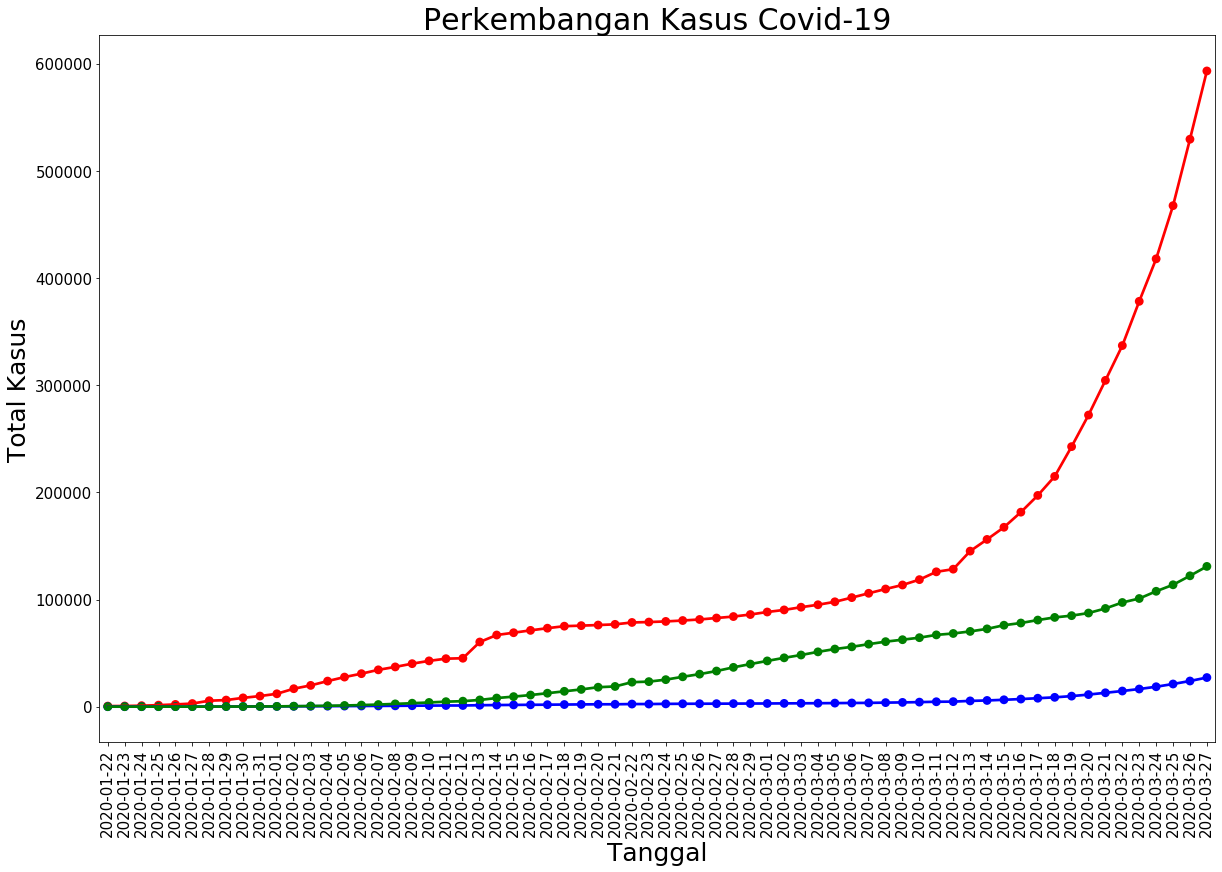

In [14]:
plt.figure(figsize= (20,13))
plt.xticks(rotation = 90 ,fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Perkembangan Kasus Covid-19" , fontsize = 30)

kasus = covid.groupby('date')['date', 'confirmed'].sum().reset_index()
kasus['date'] = pd.to_datetime(kasus['date'])
kematian = covid.groupby('date')['date', 'deaths'].sum().reset_index()
kematian['date'] = pd.to_datetime(kematian['date'])
kesembuhan = covid.groupby('date')['date', 'recovered'].sum().reset_index()
kesembuhan['date'] = pd.to_datetime(kesembuhan['date'])

ax = sns.pointplot(x = kasus.date.dt.date,y = kasus.confirmed , color = 'r')
bx = sns.pointplot(x = kematian.date.dt.date,y = kematian.deaths , color = 'b')
cx = sns.pointplot(x = kesembuhan.date.dt.date ,y = kesembuhan.recovered , color = 'g')
plt.xlabel("Tanggal",fontsize = 25)
plt.ylabel("Total Kasus",fontsize = 25)

Dalam grafik di atas, garis berwarna merah melambangkan perkembangan kasus terkonfirmasi, garis berwarna hijau melambangkan perkembangan angka kesembuhan, serta garis berwarna biru melambangkan perkembangan angka kematian. 

Dari sini, dapat dilihat bahwa kasus terkonfirmasi berkembang paling cepat, ditandakan dengan posisinya yang berada di paling atas. Sedangkan angka kesembuhan mengalami kenaikan dari minggu kedua Februari dan angka kematian mengalami kenaikan pada minggu ketiga Maret.

Kemudian kita akan melihat 10 negara teratas dalam kasus aktif, angka kematian, serta angka kesembuhan pada saat ini.

[Text(0, 0.5, 'Negara'), Text(0.5, 0, 'Total Kasus')]

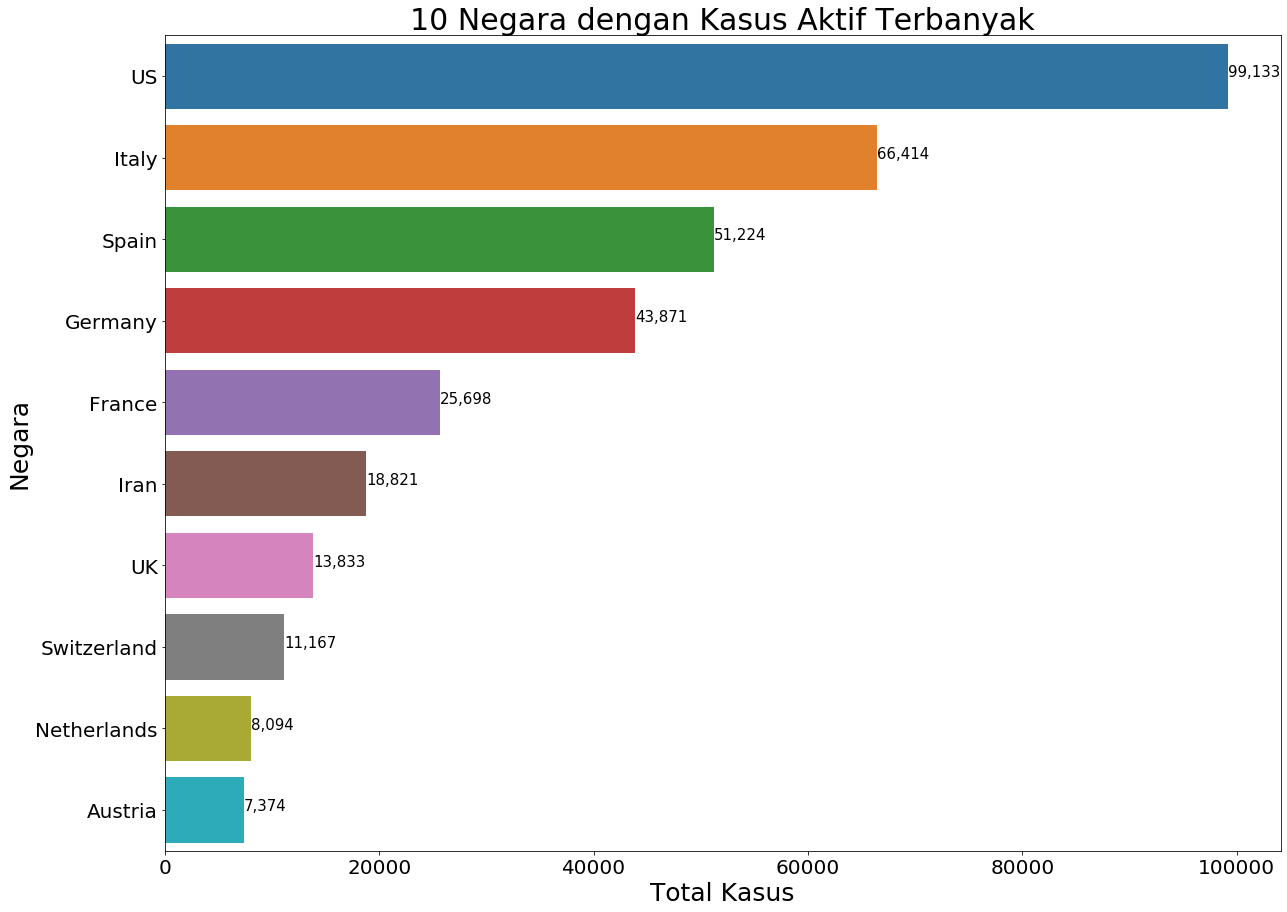

In [15]:
topactive = terbaru.groupby('country')['active'].sum().sort_values(ascending = False).head(10).reset_index()

plt.figure(figsize= (20,15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Total Kasus",fontsize = 25)
plt.ylabel("Negara",fontsize = 25)
plt.title("10 Negara dengan Kasus Aktif Terbanyak" , fontsize = 30)
ax = sns.barplot(x = topactive.active, y = topactive.country)
for i, (value, name) in enumerate(zip(topactive.active, topactive.country)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=15, ha='left',  va='center')
ax.set(xlabel='Total Kasus', ylabel='Negara')

Jadi, 10 negara dengan kasus aktif terbanyak pada saat ini adalah: Amerika Serikat, Italia, Spanyol, Jerman, Prancis, Iran, Inggris, Swiss, Belanda, dan Austria. 

[Text(0, 0.5, 'Negara'), Text(0.5, 0, 'Total Kasus')]

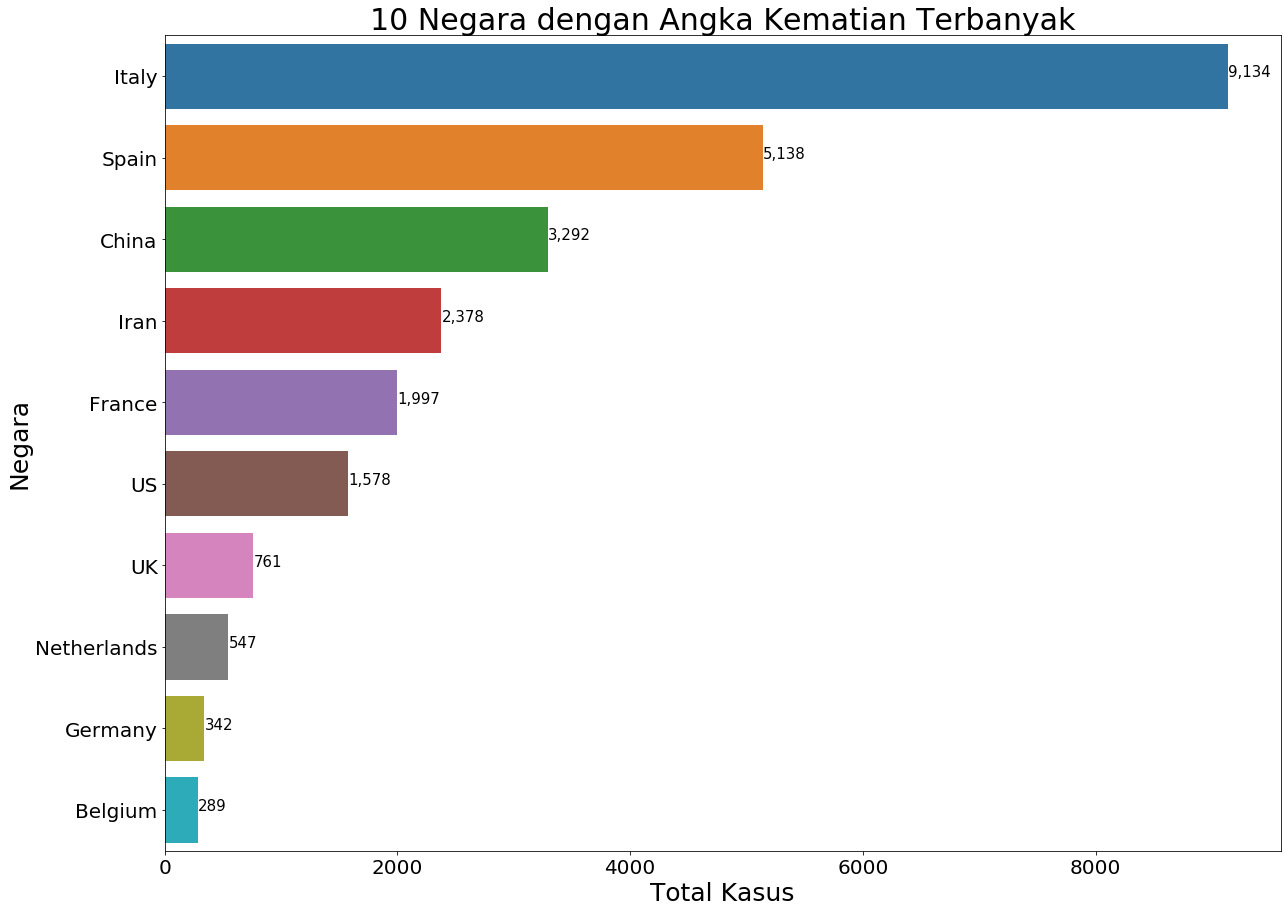

In [16]:
topdeaths = terbaru.groupby('country')['deaths'].sum().sort_values(ascending = False).head(10).reset_index()

plt.figure(figsize= (20,15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Total Kasus",fontsize = 25)
plt.ylabel("Negara",fontsize = 25)
plt.title("10 Negara dengan Angka Kematian Terbanyak" , fontsize = 30)
ax = sns.barplot(x = topdeaths.deaths, y = topdeaths.country)
for i, (value, name) in enumerate(zip(topdeaths.deaths, topdeaths.country)):
    ax.text(value, i-.05, f'{value:,.0f}', size=15, ha='left',  va='center')
ax.set(xlabel='Total Kasus', ylabel='Negara')

Jadi, 10 negara dengan angka kematian terbanyak hingga saat ini adalah: Italia, Spanyol, Cina, Iran, Prancis, Amerika Serikat, Inggris, Belanda, Jerman, dan Belgia. 

[Text(0, 0.5, 'Negara'), Text(0.5, 0, 'Total Kasus')]

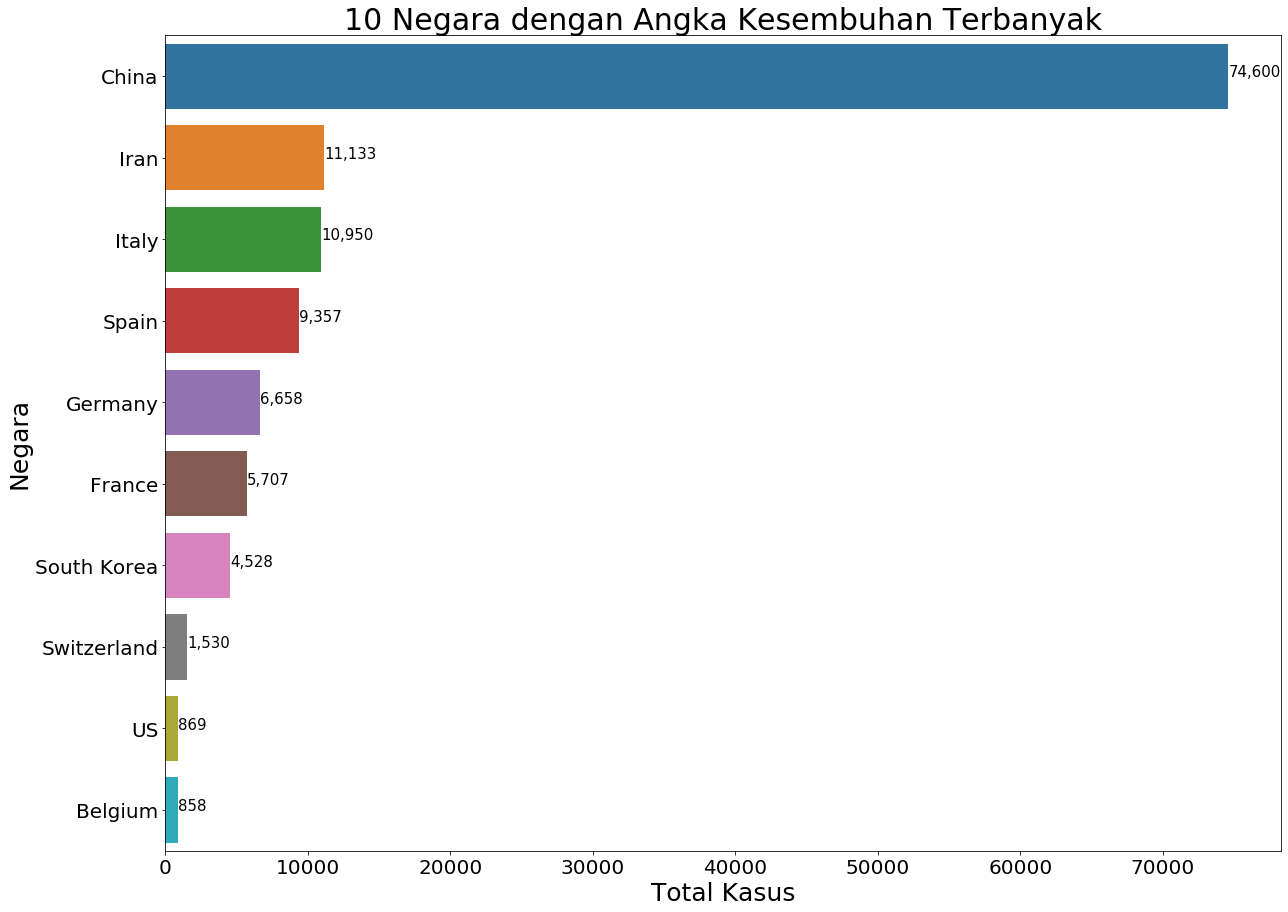

In [17]:
topsembuh = terbaru.groupby('country')['recovered'].sum().sort_values(ascending = False).head(10).reset_index()

plt.figure(figsize= (20,15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Total Kasus",fontsize = 25)
plt.ylabel("Negara",fontsize = 25)
plt.title("10 Negara dengan Angka Kesembuhan Terbanyak" , fontsize = 30)
ax = sns.barplot(x = topsembuh.recovered, y = topsembuh.country)
for i, (value, name) in enumerate(zip(topsembuh.recovered, topsembuh.country)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=15, ha='left',  va='center')
ax.set(xlabel='Total Kasus', ylabel='Negara')

Jadi, 10 negara dengan angka kesembuhan terbanyak adalah: Cina, Iran, Italia, Spanyol, Jerman, Prancis, Korea Selatan, Swiss, US, dan Belgia.

Dari ketiga histogram di atas, terdapat beberapa informasi yang bisa didapat:
1. Walaupun Amerika Serikat merupakan negara dengan kasus terbanyak saat ini, angka kematiannya masih lebih sedikit dibandingkan dengan Italia (kasus terbanyak ke-2).
2. Cina bukan merupakan negara yang masuk ke 10 negara dengan kasus aktif terbanyak pada saat ini, namun tingkat kematiannya berada pada peringkat 3 sementara kesembuhannya berada pada peringkat 1.
3. Kebanyakan negara yang memiliki kasus aktif terbanyak merupakan negara-negara Eropa (delapan dari sepuluh negara).

Selanjutnya jumlah kasus aktif, kematian, dan kesembuhan akan divisualisasikan menurut peta negaranya.

In [18]:
aktif = px.choropleth(dunia, locations="country", 
                    locationmode='country names', color="active", 
                    hover_name="country", range_color=[1,2000], 
                    color_continuous_scale="reds", 
                    title='Kasus Aktif Per Negara (27/03/2020)')
aktif.show()

Dari visualisasi peta ini, semakin merah warna suatu negara maka semakin banyak kasus aktif yang berada di sana dan semakin putih warna negara maka semakin sedikit kasus aktifnya.

In [19]:
death = px.choropleth(dunia, locations="country", 
                    locationmode='country names', color="deaths", 
                    hover_name="country", range_color=[1,100], 
                    color_continuous_scale="blues", 
                    title='Angka Kematian Tiap Negara (27/03/2020)')
death.show()

Dari visualisasi peta ini, semakin biru warna suatu negara maka semakin banyak kasus kematian yang berada di sana dan semakin putih warna negara maka semakin sedikit kasus kematiannya.

In [20]:
sembuh = px.choropleth(dunia, locations="country", 
                    locationmode='country names', color="recovered", 
                    hover_name="country", range_color=[1,100], 
                    color_continuous_scale="greens", 
                    title='Angka Kesembuhan Tiap Negara (27/03/2020)')
sembuh.show()

Dari visualisasi peta ini, semakin hijau warna suatu negara maka semakin banyak kasus kesembuhan yang berada di sana dan semakin putih warna negara maka semakin sedikit kasus kesembuhannya.

Ketiga visualisasi peta tersebut memiliki informasi sebagai berikut:
- Kebanyakan negara yang berada di Afrika dan Amerika Selatan merupakan negara yang paling sedikit terpengaruh oleh inveksi Covid-19.

### Covid-19 di Beberapa Negara yang Terpengaruh Terbanyak

Di bawah ini, notebook akan menampilkan grafik perkembangan kasus Covid-19 di beberapa negara:

1. China

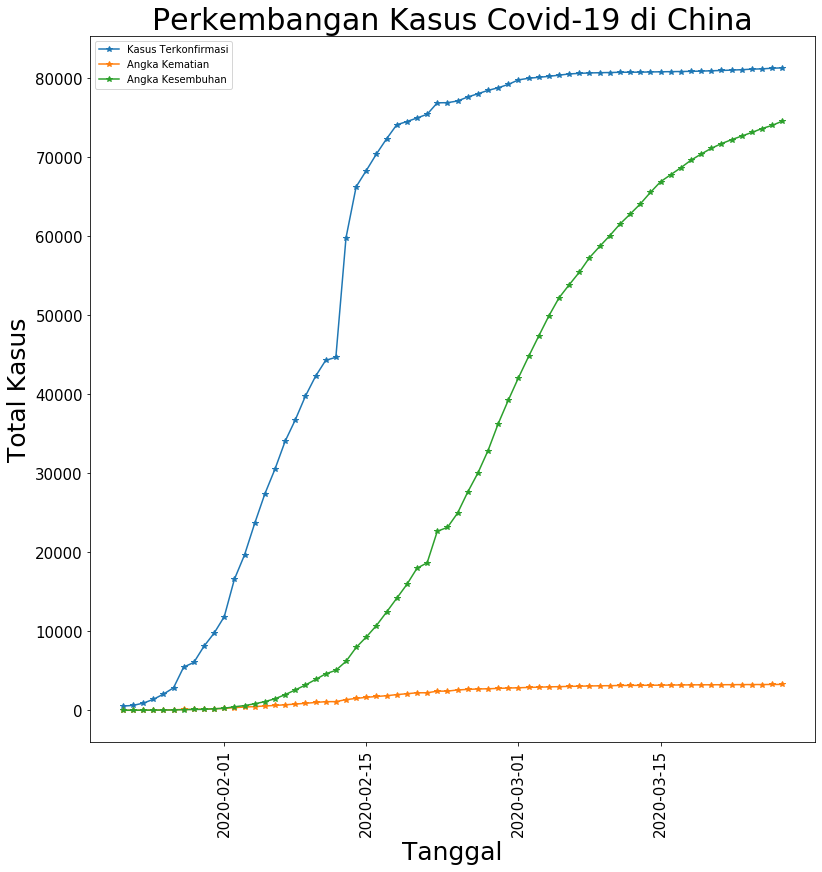

In [21]:
china = covid[covid["country"] == "China"]
pertanggal_china = china.groupby('date').agg({"confirmed":'sum', "recovered":'sum', "deaths":'sum'})

plt.figure(figsize = (13,13))
plt.xticks(rotation = 90 ,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Tanggal",fontsize = 25)
plt.ylabel("Total Kasus",fontsize = 25)
plt.title("Perkembangan Kasus Covid-19 di China" , fontsize = 30)

plt.plot(pertanggal_china["confirmed"], marker='*', label="Kasus Terkonfirmasi")
plt.plot(pertanggal_china["deaths"], marker='*', label="Angka Kematian")
plt.plot(pertanggal_china["recovered"], marker='*', label="Angka Kesembuhan")

plt.legend()

China merupakan negara di mana kasus Covid-19 pertama kali terdeteksi, tepatnya di Wuhan. Covid-19 sendiri merupakan sebuah virus baru dari jenis Corona yang dapat menyebar melalui sentuhan antar manusia, udara yang terkontaminasi, serta permukaan benda mati. Masa inkubasinya memiliki rentang waktu 2-14 hari, dengan atau tanpa menunjukkan tanda-tanda terinfeksi. Oleh karena itu dapat dilihat bahwa di awal penyebaran virus di Cina, kasusnya dapat melonjak dengan cepat (diasumsikan pasien terinfeksi tanpa diketahui). 

2. Italia

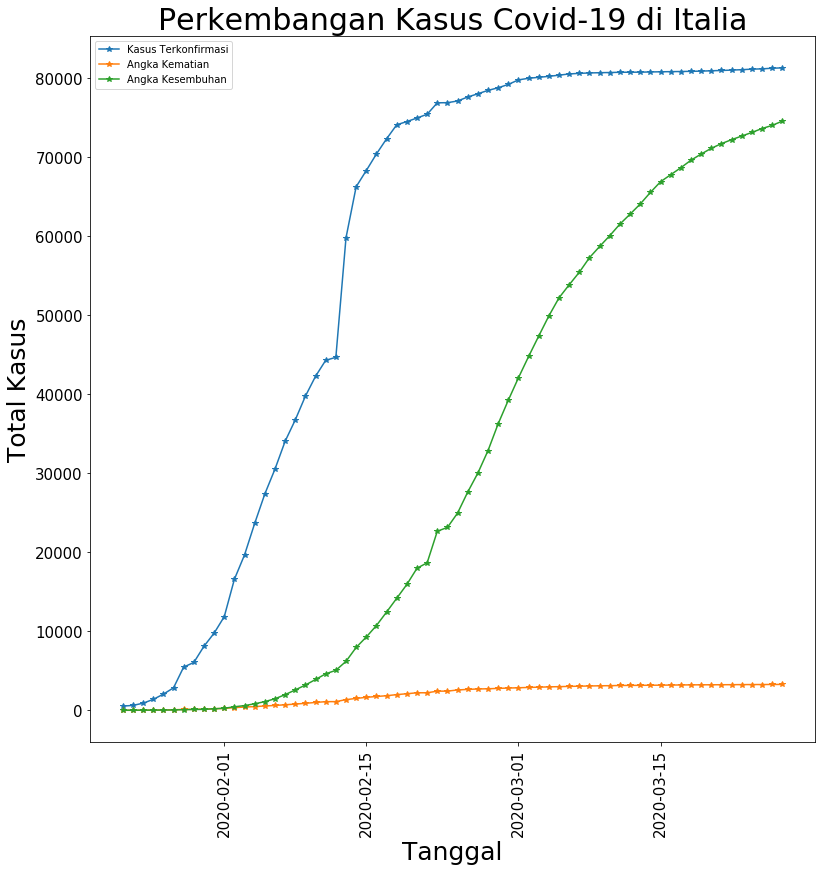

In [22]:
italy = covid[covid["country"] == "Italy"]
pertanggal_italy = china.groupby('date').agg({"confirmed":'sum', "recovered":'sum', "deaths":'sum'})

plt.figure(figsize = (13,13))
plt.xticks(rotation = 90 ,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Tanggal",fontsize = 25)
plt.ylabel("Total Kasus",fontsize = 25)
plt.title("Perkembangan Kasus Covid-19 di Italia" , fontsize = 30)

plt.plot(pertanggal_italy["confirmed"], marker='*', label="Kasus Terkonfirmasi")
plt.plot(pertanggal_italy["deaths"], marker='*', label="Angka Kematian")
plt.plot(pertanggal_italy["recovered"], marker='*', label="Angka Kesembuhan")

plt.legend()

Perkembangan Covid-19 di Italia, sama seperti di Cina, diawali dengan lonjakan yang tinggi dari akhir bulan Januari. Lonjakan kasus ini ada hubungannya dengan warga yang tidak menghiraukan himbauan untuk mengisolasi diri dari pemerintah, yang semakin mempermudah penyebaran virus. Hingga sekarang, seluruh Italia berada dalam status lockdown untuk mengurangi penyebaran virus.

3. Amerika Serikat

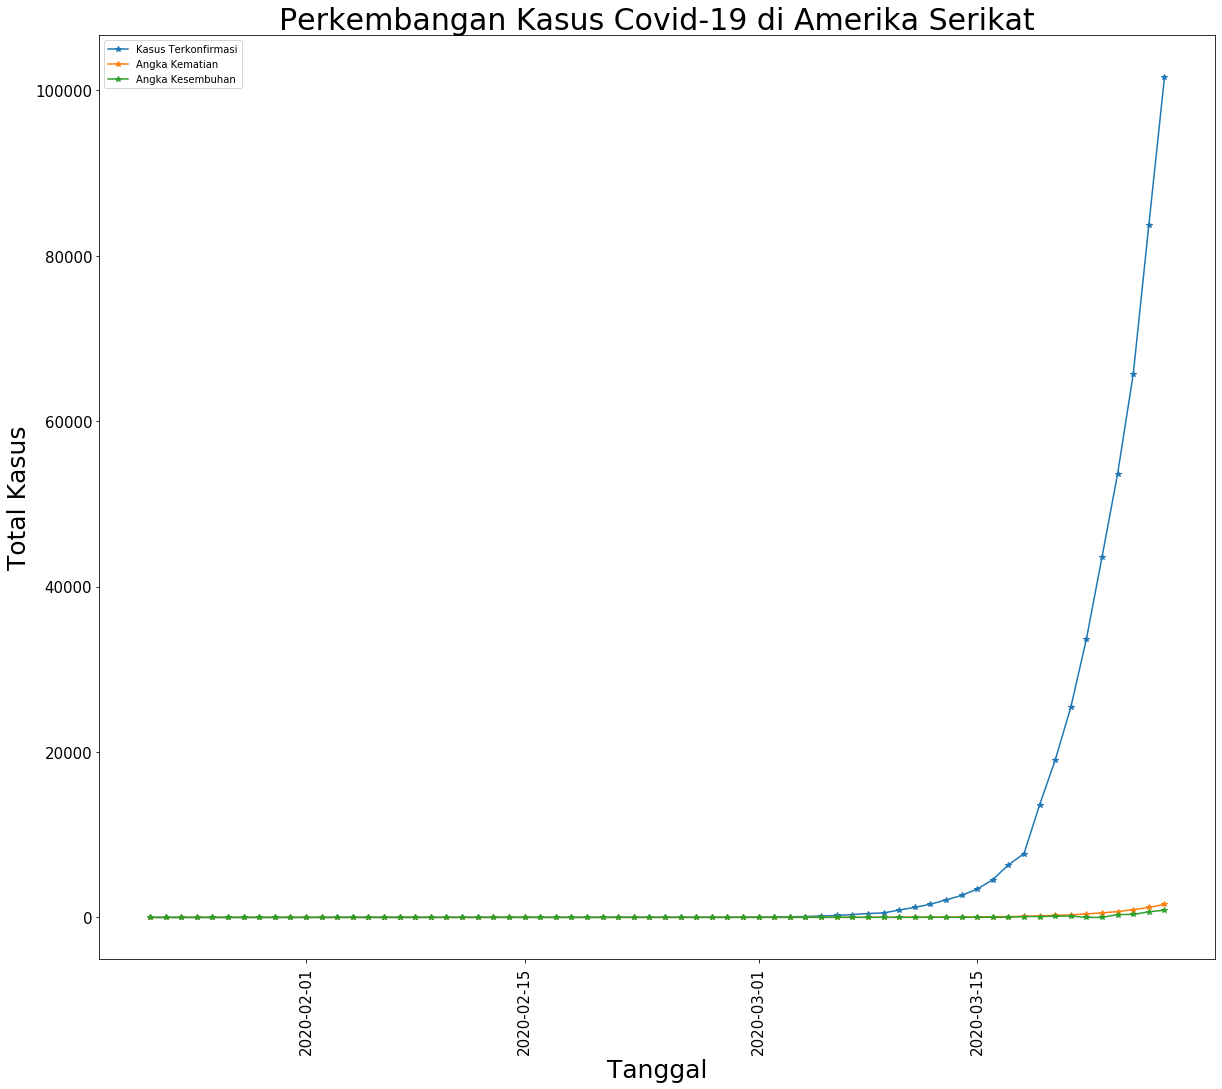

In [23]:
us = covid[covid["country"] == "US"]
pertanggal_us = us.groupby('date').agg({"confirmed":'sum', "recovered":'sum', "deaths":'sum'})

plt.figure(figsize = (20,17))
plt.xticks(rotation = 90 ,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Tanggal",fontsize = 25)
plt.ylabel("Total Kasus",fontsize = 25)
plt.title("Perkembangan Kasus Covid-19 di Amerika Serikat" , fontsize = 30)

plt.plot(pertanggal_us["confirmed"], marker='*', label="Kasus Terkonfirmasi")
plt.plot(pertanggal_us["deaths"], marker='*', label="Angka Kematian")
plt.plot(pertanggal_us["recovered"], marker='*', label="Angka Kesembuhan")

plt.legend()

Penyebaran kasus di Amerika Serikat sendiri baru mengalami kenaikan yang sangat signifikan pada awal bulan Maret. Saat ini, kasusnya tercatat sebanyak lebih dari 100.000 kasus.

### Covid-19 di Indonesia

Sementara itu, bagaimana dengan penyebaran kasus Covid-19 di Indonesia sendiri? Di bawah ini terdapat grafik yang akan memvisualisasikannya.

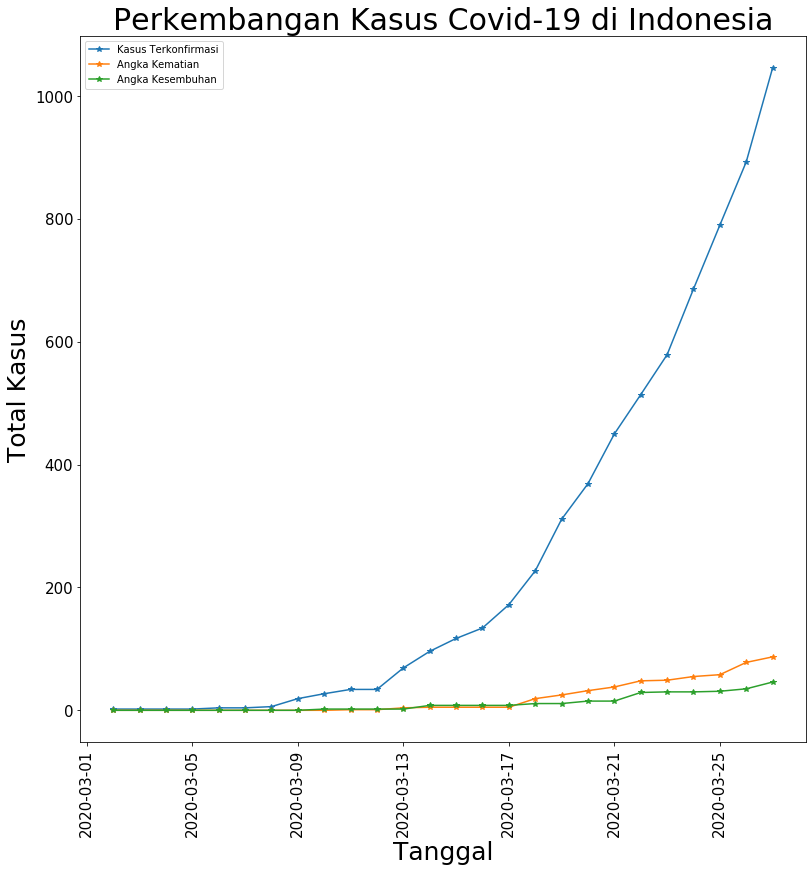

In [24]:
indo = covid[covid["country"] == "Indonesia"]
pertanggal_indo = indo.groupby('date').agg({"confirmed":'sum', "recovered":'sum', "deaths":'sum'})

plt.figure(figsize = (13,13))
plt.xticks(rotation = 90 ,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Tanggal",fontsize = 25)
plt.ylabel("Total Kasus",fontsize = 25)
plt.title("Perkembangan Kasus Covid-19 di Indonesia" , fontsize = 30)

plt.plot(pertanggal_indo["confirmed"], marker='*', label="Kasus Terkonfirmasi")
plt.plot(pertanggal_indo["deaths"], marker='*', label="Angka Kematian")
plt.plot(pertanggal_indo["recovered"], marker='*', label="Angka Kesembuhan")

plt.legend()

Dari grafik tersebut, dapat dilihat bahwa Covid-19 baru terdeteksi ke Indonesia pada awal bulan Maret 2020. Perkembangannya sendiri baru mulai naik secara teratur pada minggu kedua bulan Maret. Berbeda dengan Cina dan Italia, pasien Covid-19 di Indonesia memiliki angka kematian yang lebih tinggi dibandingkan dengan angka kesembuhannya. 

Meski begitu, data yang ada sekarang ini tidak dapat disimpulkan sebagai data akurat yang merepresentasikan keseluruhan warga Indonesia. Ini disebabkan karena kebanyakan pasien di Indonesia baru melakukan pengecekan ketika telah menunjukkan tanda-tanda terinfeksi/telah parah, serta tidak adanya pemberlakuan tes secara massal.

## Data Mining

Untuk Data Mining, notebook akan menampilkan beberapa prediksi terhadap kasus terkonfirmasi dan kasus kematian Covid-19. Sebelum itu, kita akan memisahkan data menjadi data yang diperrgunakan untuk training serta data yang valid.

In [25]:
pertanggal["Sejak"]=pertanggal.index-pertanggal.index[0]
pertanggal["Sejak"]=pertanggal["Sejak"].dt.days

trained=pertanggal.iloc[:int(pertanggal.shape[0]*0.80)]
valid=pertanggal.iloc[int(pertanggal.shape[0]*0.80):]
model=[]

Setelah dipisah, barulah Data Mining dapat dimulai. Proses ini akan menggunakan beberapa metode, yaitu:

### 1. SVM

Support Vector Machine merupakan sebuah metode supervised learning yang digunakan untuk klasifikasi atau regresi. Dalam notebook ini, kita akan menggunakan versi klasifikasinya yaitu Support Vector Classification. 

Mulai dengan mendefinisikan parameternya.

In [26]:
svm=SVR(degree=3)
param_svm={'kernel':['linear','rbf','poly'],
          'C':[0.1,1,0.01],
          'gamma':[0.1,1,0.01],
          'epsilon':[0.1,1,0.01]}

Karena akan membuat prediksi kasus terkonfirmasi dan kasus kematian, maka akan dibuat dua fungsi untuk memudahkan.

In [27]:
svm_cv1=GridSearchCV(estimator=svm,param_grid=param_svm,cv=5)
svm_cv2=GridSearchCV(estimator=svm,param_grid=param_svm,cv=5)

#### Kasus Terkonfirmasi

Untuk menggunakan svm, kita perlu mencocokkan dataset yang digunakan dengan GridSearchCV. Setelah itu, cari best estimatornya

In [28]:
svm_cv1.fit(np.array(trained["Sejak"]).reshape(-1,1),np.array(trained["confirmed"]).reshape(-1,1))

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 0.01], 'epsilon': [0.1, 1, 0.01],
                         'gamma': [0.1, 1, 0.01],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
svm_cv1.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Setelah itu, kalkulasi jumlah eror klasifikasi SVM.

In [30]:
svm_conf=svm_cv1.best_estimator_.predict(np.array(valid["Sejak"]).reshape(-1,1))

model.append(np.sqrt(mean_squared_error(valid["confirmed"],svm_conf)))

print("Eror Akar Pangkat Dua untuk SVM Kasus Terkonfirmasi: ",np.sqrt(mean_squared_error(valid["confirmed"],svm_conf)))

Eror Akar Pangkat Dua untuk SVM Kasus Terkonfirmasi:  153721.299315652


Terakhir, buat visualisasi hasil training data yang digunakan SVM untuk dibandingkan dengan data sebenarnya.

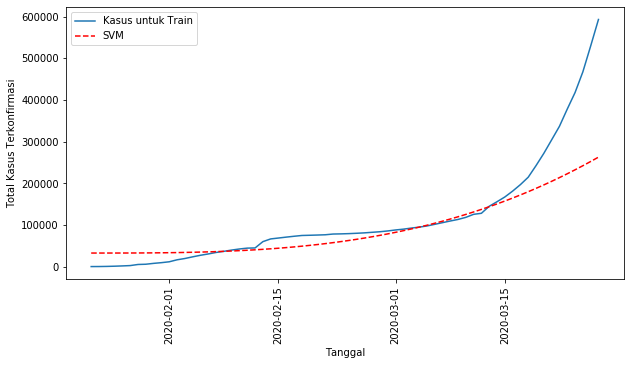

In [31]:
plt.figure(figsize=(10,5))
conf_svm=svm_cv1.best_estimator_.predict(np.array(pertanggal["Sejak"]).reshape(-1,1))
plt.plot(pertanggal["confirmed"],label="Kasus untuk Train")
plt.plot(pertanggal.index,conf_svm, linestyle='--',label="SVM",color='red')
plt.xlabel('Tanggal')
plt.ylabel('Total Kasus Terkonfirmasi')
plt.xticks(rotation=90)
plt.legend()

Dari hasil prediksi di atas, dapat terlihat bahwa SVM masih kurang dapat memprediksi dengan tepat sesuai dengan data yang ada. Ini disimpulkan dari perbedaan garis yang dilalui prediksi SVM dengan kasus yang sebenarnya.

#### Kasus Kematian

Untuk prediksi ini, ulangi langkah yang sama seperti pada prediksi sebelumnya.

In [32]:
svm_cv2.fit(np.array(trained["Sejak"]).reshape(-1,1),np.array(trained["deaths"]).reshape(-1,1))

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 0.01], 'epsilon': [0.1, 1, 0.01],
                         'gamma': [0.1, 1, 0.01],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
svm_cv2.best_estimator_

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
svm_death=svm_cv2.best_estimator_.predict(np.array(valid["Sejak"]).reshape(-1,1))

model.append(np.sqrt(mean_squared_error(valid["deaths"],svm_death)))

print("Eror Akar Pangkat Dua untuk SVM Kasus Kematian: ",np.sqrt(mean_squared_error(valid["deaths"],svm_death)))

Eror Akar Pangkat Dua untuk SVM Kasus Kematian:  10900.469767345328


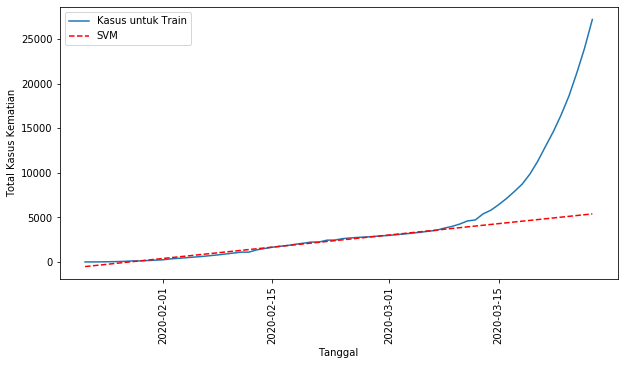

In [35]:
plt.figure(figsize=(10,5))
death_svm=svm_cv2.best_estimator_.predict(np.array(pertanggal["Sejak"]).reshape(-1,1))
plt.plot(pertanggal["deaths"],label="Kasus untuk Train")
plt.plot(pertanggal.index,death_svm, linestyle='--',label="SVM",color='red')
plt.xlabel('Tanggal')
plt.ylabel('Total Kasus Kematian')
plt.xticks(rotation=90)
plt.legend()

Dari hasil prediksi di atas, dapat terlihat bahwa SVM belum dapat memprediksi dengan tepat sesuai dengan data yang ada. Ini disimpulkan dari perbedaan garis yang dilalui prediksi SVM yang berada di bawah garis yang dilalui kasus yang sebenarnya mulai dari minggu kedua bulan Maret, walaupun pada awal perkembangan Covid prediksi SVM betul.

### 2. Holt Linear Model

Holt Linear Model adalah sebuah model prediksi smoothing dengan trend yang menggunakan tiga persamaan berbeda untuk membentuk prediksinya, yaitu persamaan smoothing dasar, persamaan yang digunakan untuk membedakan nilai smoothing, serta persamaan yang digunakan untuk menghasilkan prediksi akhir.

Mulai dengan membuat persamaan dengan level smoothingnya.

In [36]:
holt=Holt(np.asarray(trained["confirmed"])).fit(smoothing_level=1.2, smoothing_slope=1.3)
h_pred=valid.copy()
holt1=Holt(np.asarray(trained["deaths"])).fit(smoothing_level=1.2, smoothing_slope=1.3)
d_pred=valid.copy()

#### Kasus Terkonfirmasi

Hitung jumlah eror dari model ini melalui kode berikut:

In [37]:
h_pred["Holt"]=holt.forecast(len(valid))
model.append(np.sqrt(mean_squared_error(h_pred["confirmed"],h_pred["Holt"])))
print("Eror Akar Pangkat Dua Holt Linear Model Kasus Terkonfirmasi: ",np.sqrt(mean_squared_error(h_pred["confirmed"],h_pred["Holt"])))

Eror Akar Pangkat Dua Holt Linear Model Kasus Terkonfirmasi:  47023.44841050071


Kemudian, buat visualisasinya menggunakan library matplotlib.pyplot.

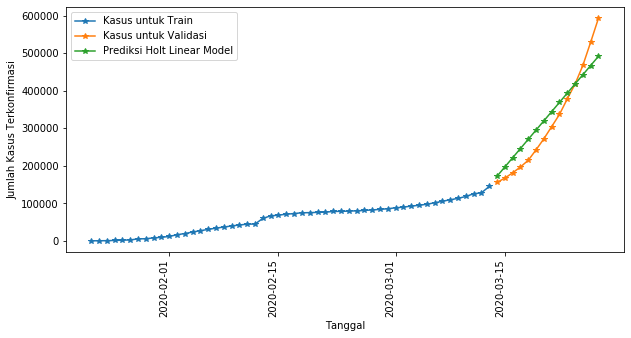

In [38]:
plt.figure(figsize=(10,5))
plt.plot(trained.confirmed,label="Kasus untuk Train",marker='*')
valid.confirmed.plot(label="Kasus untuk Validasi",marker='*')
h_pred.Holt.plot(label="Prediksi Holt Linear Model",marker='*')
plt.ylabel("Jumlah Kasus Terkonfirmasi")
plt.xlabel("Tanggal")
plt.xticks(rotation=90)
plt.legend()

Dari hasil prediksi di atas, dapat terlihat bahwa Holt Linear Model masih kurang dapat memprediksi dengan tepat sesuai dengan data yang ada. Perbedaan ini awalnya lebih tinggi dibanding jumlah kasus yang ada, namun kemudian lebih rendah dibanding jumlah kasus.

#### Kasus Kematian

Ulangi langkah yang sama seperti prediksi untuk kasus terkonfirmasi sebelumnya.

In [39]:
d_pred["Holt"]=holt1.forecast(len(valid))
model.append(np.sqrt(mean_squared_error(d_pred["deaths"],d_pred["Holt"])))
print("Akar Pangkat Dua Holt Linear Model Kasus Kematian: ",np.sqrt(mean_squared_error(d_pred["deaths"],d_pred["Holt"])))

Akar Pangkat Dua Holt Linear Model Kasus Kematian:  2382.8579286619565


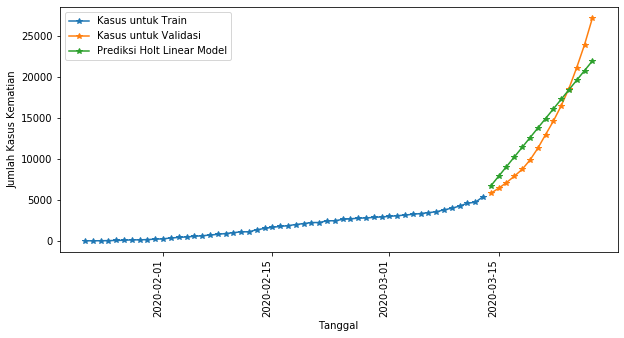

In [40]:
plt.figure(figsize=(10,5))
plt.plot(trained.deaths,label="Kasus untuk Train",marker='*')
valid.deaths.plot(label="Kasus untuk Validasi",marker='*')
d_pred.Holt.plot(label="Prediksi Holt Linear Model",marker='*')
plt.ylabel("Jumlah Kasus Kematian")
plt.xlabel("Tanggal")
plt.xticks(rotation=90)
plt.legend()

Dari hasil prediksi di atas, dapat terlihat bahwa Holt Linear Model masih kurang dapat memprediksi dengan tepat sesuai dengan data yang ada. Perbedaan ini awalnya lebih tinggi dibanding jumlah kasus yang ada, namun kemudian lebih rendah dibanding jumlah kasus.

### Kesimpulan Data Mining

Setelah menggunakan dua metode untuk data mining, yaitu klasifikasi SVM dan prediksi Holt Linear Model, dapat disimpulkan bahwa masih terdapat eror dalam membuat prediksi yang akurat untuk menghitung jumlah kasus terkonfirmasi dan kasus kematian terkait Covid-19. Eror ini dapat disebabkan oleh kurangnya data yang menjadi sampel atau memerlukan perbandingan dengan metode klasifikasi/klustering/prediksi lainnya. 

## Kesimpulan Notebook

Dari uraian EDA dan Data Mining di atas, dapat disimpulkan bahwa:
1. Terdapat tiga bulan rentang waktu dalam dataset, dari 22 Januari 2020 sampai 27 Maret 2020.
2. Per tanggal 27 Maret 2020 terdapat 176 negara dan teritori berbeda yang memiliki kasus aktif, dengan top 10 sebagai berikut:
    - Top 10 kasus aktif: Amerika Serikat, Italia, Spanyol, Jerman, Prancis, Iran, Inggris, Swiss, Belanda, dan Austria.
    - Top 10 kasus kematian: Italia, Spanyol, Cina, Iran, Prancis, Amerika Serikat, Inggris, Belanda, Jerman, dan Belgia.
    - Top 10 kasus kesembuhan: Cina, Iran, Italia, Spanyol, Jerman, Prancis, Korea Selatan, Swiss, US, dan Belgia.
   Negara-negara di Amerika Selatan dan Afrika merupakan negara yang paling sedikit terpengaruh oleh Covid-19 (sedikit kasus terkonfirmasi ditemukan).
3. Dari beberapa negara yang paling banyak terpengaruh, Amerika Serikat merupakan yang pertumbuhan kasus terkonfirmasinya lumayan lambat (baru melonjak awal Maret).
4. Di Indonesia, Covid-19 baru terdeteksi di awal bulan Maret 2020. Meski begitu, karena kurangnya sampel data, belum tentu data yang ada dapat disebut akurat.
5. Dari hasil prediksi yang dihasilkan klasifikasi SVM, belum bisa memprediksi secara akurat dari data training, karena cenderung memiliki kurva yang lebih rendah dibanding data sesungguhnya.
6. Dari hasil prediksi yang dihasilkan model prediksi Holt Linear Model, belum bisa memprediksi secara akurat dari data training, terlebih apabila terjadi lonjakan yang signifikan dan/atau terbentuk kurva.
7. Eror dapat disebabkan kurangnya sampel data atau kurangnya perbandingan dengan model lain.